$$%
\newcommand{\BB}{{\boldsymbol B}}%
\newcommand{\cc}{{\boldsymbol c}}%
\let\dd\relax%
\newcommand{\dd}{{\boldsymbol d}}%
\newcommand{\DD}{{\boldsymbol D}}%
\newcommand{\Id}{{\boldsymbol I}}%
\newcommand{\HH}{{\boldsymbol H}}%
\newcommand{\RR}{{\boldsymbol R}}%
\newcommand{\TT}{{\boldsymbol T}}%
\newcommand{\VV}{{\boldsymbol V}}%
\newcommand{\WW}{{\boldsymbol W}}%
\newcommand{\ww}{{\boldsymbol w}}%
\newcommand{\XX}{{\boldsymbol X}}%
\renewcommand{\aa}{{\boldsymbol a}}%
\newcommand{\xx}{{\boldsymbol x}}%
\newcommand{\yy}{{\boldsymbol y}}%
% Math Symbols
\newcommand{\rrh}{{\boldsymbol \rho}}%
\newcommand{\mmu}{{\boldsymbol \mu}}%
\newcommand{\ssi}{{\boldsymbol \sigma}}%
\newcommand{\SSi}{{\boldsymbol \Sigma}}%
\newcommand{\eps}{{\boldsymbol \epsilon}}%
\newcommand{\GGa}{{\boldsymbol \Gamma}}%
\newcommand{\bz}{{\boldsymbol 0}}%
\DeclareMathOperator{\car}{CAR}%
\newcommand{\N}{\mathcal N}%
\newcommand{\iid}{\stackrel{iid}{\sim}}%
\newcommand{\ud}{\, \mathrm{d}}%
\newcommand{\tmin}{t_{\mathrm{min}}}%
\newcommand{\tmax}{t_{\mathrm{max}}}%
\newcommand{\carp}{\mathrm{CAR}(p)}
$$
# probDE: Probabilistic solution of ordinary differential equations

*Mohan Wu, Martin Lysy*

---

## Description

**probDE** is a Python library that uses [probabilistic numerics](http://probabilistic-numerics.org/) to solve ordinary differential equations (ODEs).  That is, most ODE solvers (such as [Euler's method](https://en.wikipedia.org/wiki/Euler_method)) produce a deterministic approximation to the ODE on a grid of size $\delta$.  As $\delta$ goes to zero, the approximation converges to the true ODE solution.  Probabilistic solvers such as **probDE** also output a solution an a grid of size $\delta$; however, the solution is random.  Still, as $\delta$ goes to zero we get the correct answer.

**probDE** provides a probabilistic solver for univariate ordinary differential equations (ODEs) of the form

\begin{equation*}
  \ww'\xx_t = f(\xx_t, t), \qquad \xx_L = \aa,
\end{equation*}

where $\xx_t = \big(x_t^{(0)}, x_t^{(1)}, ..., x_t^{(q)}\big)$ consists of the first $q$ derivatives of the process $x_t = x_t^{(0)}$, and a solution is sought on the interval $t \in [L, U]$.  

**probDE** implements the probabilistic solver of [Chkrebtii et al (2016)](https://projecteuclid.org/euclid.ba/1473276259).  This begins by putting a [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process) prior on the ODE solution, and updating it sequentially as the solver steps through the grid.

## Walkthrough

To illustrate, let's consider the following ODE example of order $q = 2$:

\begin{equation*}
x_t^{(2)} = \sin(2t) − x_t^{(0)}, \qquad \xx_0 = (-1, 0, 1),
\end{equation*}

where the solution $x_t$ is sought on the interval $t \in [0, 10]$.  In this case, the ODE has an analytic solution,

\begin{equation*}
x_t = \tfrac 1 3 \big(2\sin(t) - 3\cos(t) - \sin(2t)\big).
\end{equation*}

To approximate the solution with the probabilistic solver, the Gaussian process prior we will use is a so-called [Continuous Autoregressive Process](https://CRAN.R-project.org/package=cts/vignettes/kf.pdf) of order $p$, 

\begin{equation*}
\XX_t \sim \car_p(\mmu, \rrh, \sigma).
\end{equation*}

Here $\XX_t = \big(x_t^{(0)}, ..., x_t^{(p-1)}\big)$ consists of $x_t$ and its first $p-1$ derivatives. The $\carp$ model specifies that each of these is continuous, but $x_t^{(p)}$ is not. Therefore, we need to pick $p > q$. It's usually a good idea to have $p$ a bit larger than $q$, especially when we think that the true solution $x_t$ is smooth. However, increasing $p$ also increases the computational burden, and doesn't necessarily have to be large for the solver to work.  For this example, we will use $p=4$. The tuning parameters of the $\carp$ prior are:

- The mean vector $\mmu$.  By default we will set this to 0.
- The scale parameter $\sigma$.
- The "roots" of the process $\rrh = (\rho_0, \ldots, \rho_{p-1})$.  These can be any distinct set of negative numbers.  We suggest parametrizing them as $\rho_0 = -1/\tau$ and $\rho_k = -(1 + \tfrac{k}{10(p-1)})$ for $k > 0$, in which case $\tau$ becomes a decorrelation-time parameter.

Finally, we need a way to initialize the remaining derivatives $\yy_t = \big(x_t^{(q+1)}, ..., x_t^{(p-1)}\big)$ at time $t = L$. Since the $\carp$ process has a multivariate normal stationary distribtuion, we suggest initializing $\yy_L \sim p(\yy_L \mid \xx_L = \aa)$, i.e., as a random draw from this stationary distribution conditional on the value of $\xx_L = \aa$.  The Python code to implement all this is as follows.

In [1]:
# Imports needed
from math import sin, cos
import numpy as np
import matplotlib.pyplot as plt # for plotting
from probDE.utils.utils import root_gen
from probDE.Kalman.kalman_solver import kalman_solver

In [2]:
# RHS of ODE
def ode_fun(x_t, t):
    return sin(2*t) - x_t[0]

# LHS vector of ODE
w_vec = np.array([0.0, 0.0, 1.0])

# These parameters define the order of the ODE and the CAR(p) process
q = 2 # ODE order
p = q+2 # number of continuous derivatives of CAR(p) solution prior

# it is assumed that the solution is sought on the interval [L,U].
N = 100 # Number of grids points that are evaluated; in particular, the grid size delta = (U-L)*1/N
L = 0
U = 10 

# Now we need the parameters for the solver
# First we need to generate roots, rho, for the CAR(p) prior
# We suggest using root_gen to parametrize them as desribed: rho_k = -exp(k/tau)
tau = 50 # decorrelation parameter
roots = root_gen(tau, p)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
mu = np.zeros(p)
sigma = .001

# Initial value, x0, for the IVP
a = np.array([-1.0, 0.0, 1.0])

# Run the solver to get an approximation
Xn, Xn_mean, Xn_var = kalman_solver(ode_fun, L, U, N, mu, sigma, roots, w_vec, a)

To see how well this approximation does against the exact solution, we can graph them together. First, we will define the functions of the exact solution for this example.

In [3]:
# Exact Solution for x_t^{(0)}
def ode_exact_x(t):
    return (-3*cos(t) + 2*sin(t) - sin(2*t))/3

# Exact Solution for x_t^{(1)}
def ode_exact_x1(t):
    return (-2*cos(2*t) + 3*sin(t) + 2*cos(t))/3

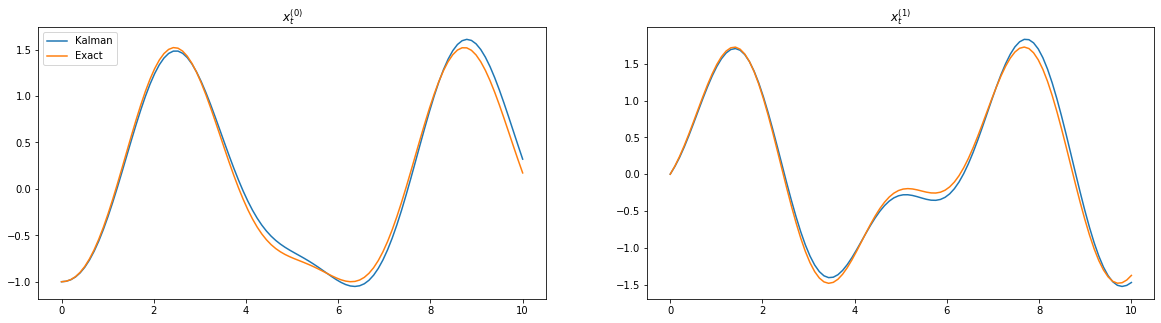

In [4]:
# Get exact solutions for x^{(0)}, x^{(1)}
tseq = np.linspace(L, U, N)
exact_x = np.zeros(N)
exact_x1 = np.zeros(N)
for t in range(N):
    exact_x[t] = ode_exact_x(tseq[t])
    exact_x1[t] = ode_exact_x1(tseq[t])

# Plot them
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(tseq, Xn[:,0], label = 'Kalman')
axs[0].plot(tseq, exact_x, label = 'Exact')
axs[0].set_title("$x^{(0)}_t$")
axs[0].legend(loc='upper left')
axs[1].plot(tseq, Xn[:,1], label = 'Kalman')
axs[1].plot(tseq, exact_x1, label = 'Exact')
axs[1].set_title("$x^{(1)}_t$")
plt.show()

### Graph in README 

To produce the graphs in the README file, we just need to run the following function. It runs `kalman_solver` for `draws` samples for each of the three `N`: 50, 100, 200. It also does the Euler method as well as getting the exact solution to compare the accuracy of the kalman draws.

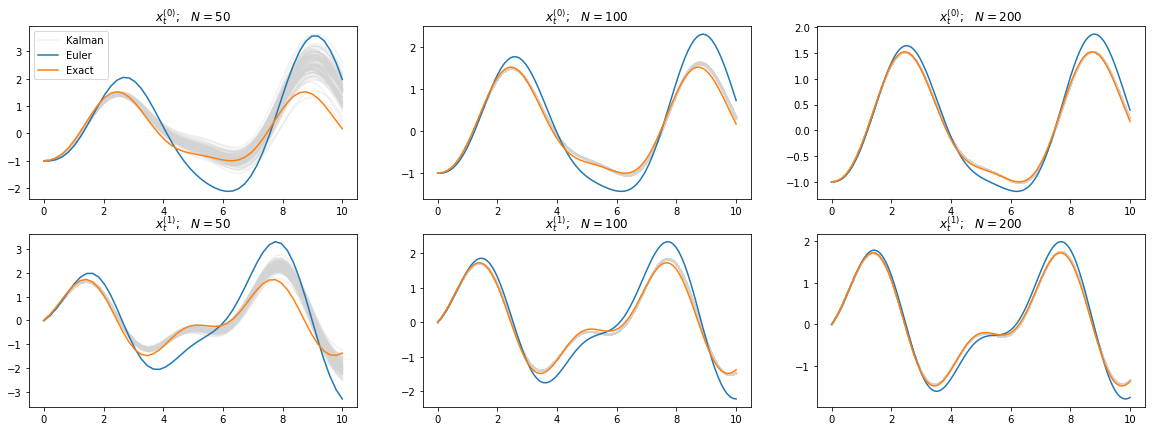

In [5]:
from probDE.Examples.readme_graph import readme_graph
draws = 100
readme_graph(ode_fun, p, L, U, N, w_vec, a, draws)

## Multivariate ODE

We will look at a multivariate ODE system called **Lorenz63**. This system has a chaotic regime depending on the initial values. For initial values $a = (-12, -5, 28)$, there is a deterministic phase which we can use to compare to the solution given by the `odeint` from `scipy`. The Lorenz equation is defined as follows:

\begin{equation}
  \begin{aligned}
    \frac{dx}{dt} &= \sigma(y - x), \\
    \frac{dy}{dt} &= x(\rho - z) - y, \\
    \frac{dz}{dt} &= xy - \beta z, \\
    \xx_0 &= (-12,-5,28).
  \end{aligned}
\end{equation}

Specifically, we will be using the parameters $(\rho, \sigma, \beta) = (28, 10, 8/3)$.

In [6]:
from scipy.integrate import odeint
from probDE.Kalman.kalman_multi_solver import kalman_multi_solver
from probDE.Examples.lorenz_graph import lorenz_graph

In [7]:
# Lorenz function used in odeint
def lorenz(state, t):
    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    x, y, z = state  # Unpack the state vector
    return -sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y 

In [8]:
# RHS of ODE
def lorenz2(X_t, t):
    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    p = 3
    x, y, z = X_t[p*0], X_t[p*1], X_t[p*2]
    return -sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y 

# LHS Matrix of ODE
w_mat = np.array([[0,1], [0,1], [0,1]])

# These parameters define the order of the ODE and the CAR(p) process
n = 3 # Number of variates
q = 1 # ODE order
p = q+2 # number of continuous derivatives of CAR(p) solution prior

# it is assumed that the solution is sought on the interval [L,U].
N = 5000 # Number of grids points that are evaluated; in particular, the grid size delta = (U-L)*1/N
L = 0
U = 20

# Now we need the parameters for the solver
# First we need to generate roots, rho, for the CAR(p) priors
# We need a set of roots and sigma for each variate
roots = root_gen(1.3, p)
rootlst = [roots*10]*n
# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = .5
sigmalst = [sigma]*n

# Initial value, a, for the IVP
x0 = [-12, -5, 38]
v0 = lorenz(x0, 0)
mu = np.zeros(n*p)
a = np.array(list(zip(x0, v0)))

# Run the solver to get an approximation
Xn, Xn_mean, Xn_var = kalman_multi_solver(lorenz2, L, U, N, mu, sigmalst, rootlst, w_mat, a)

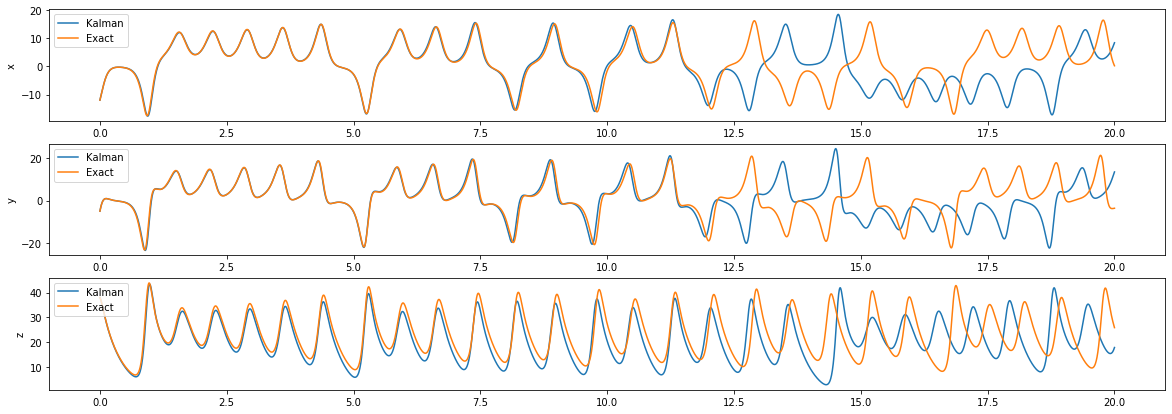

In [9]:
# Get exact solutions for the Lorenz System
tseq = np.linspace(L, U, N)
exact = odeint(lorenz, x0, tseq)

#
_, axs = plt.subplots(n, 1, figsize=(20, 7))
ylabel = ['x', 'y', 'z']
for i in range(n):
    axs[i].plot(tseq, Xn[:, p*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

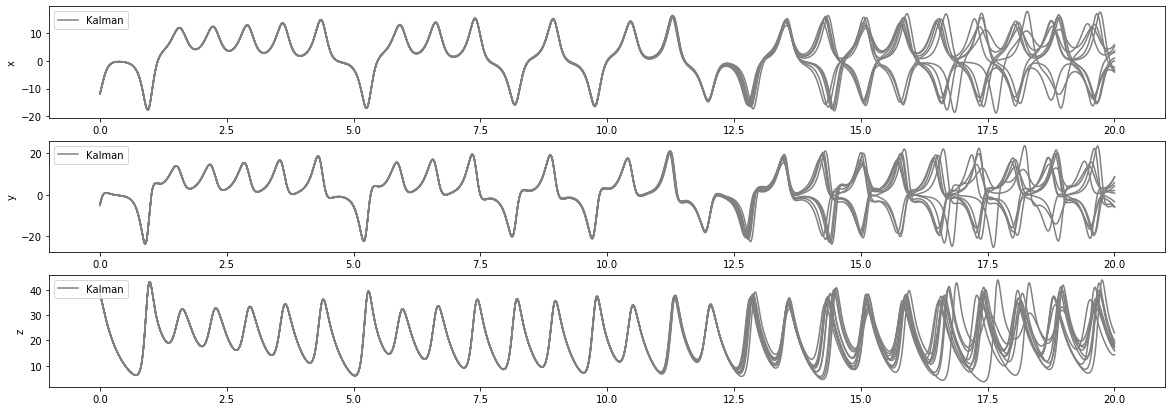

In [12]:
# Takes ~20 minutes
tau = 1.3
sigma = 0.5
draws = 1000
lorenz_graph(lorenz2, p, L, U, N, w_mat, tau, sigma, a, draws)

## Statistical Inference

For statistical inference, we'll take a look at the **FitzHugh-Nagumo** ODE:

\begin{equation}
  \begin{aligned}
    \frac{dV}{dt} &= c(V - \frac{V^3}{3} + R), \\
    \frac{dR}{dt} &= -\frac{(V - a - bR)}{c}, \\
    \xx_0 &= (-1,1).
  \end{aligned}
\end{equation}

Specifically, we will use the parameters $(a, b, c) = (.2, .2, 3)$.

In [13]:
from timeit import default_timer as timer
from scipy.integrate import odeint
from probDE.Kalman.kalman_multi_solver import kalman_multi_solver

In [14]:
def fitz(X_t, t):
    a = .2
    b = .2
    c = 3
    V, R = X_t
    return [c*(V - V**3/3 + R), -1/c*(V - a + b*R)]

In [32]:
# RHS of ODE
def fitz2(X_t, t):
    p = 3
    a = .2
    b = .2
    c = 3
    V, R = X_t[p*0], X_t[p*1]
    return [c*(V - V**3/3 + R), -1/c*(V - a + b*R)]

# LHS Matrix of ODE
w_mat = np.array([[0,1], [0,1]])

# These parameters define the order of the ODE and the CAR(p) process
n = 2 # Number of variates
q = 1 # ODE order
p = q+2 # number of continuous derivatives of CAR(p) solution prior

# it is assumed that the solution is sought on the interval [L,U].
Nlst = [8000, 4000, 2000, 800, 400] # Number of grids points that are evaluated; in particular, the grid size delta = (U-L)*1/N
L = 0
U = 40

# Now we need the parameters for the solver
# First we need to generate roots, rho, for the CAR(p) priors
# We need a set of roots and sigma for each variate
roots = root_gen(100, p)
rootlst = [roots]*n
# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = .5
sigmalst = [sigma]*n

# Initial value, a, for the IVP
x0 = [-1, 1]
v0 = fitz(x0, 0)
mu = np.zeros(n*p)
a = np.array(list(zip(x0, v0)))

# Run the solver to get an approximation
Xn, Xn_mean, Xn_var = kalman_multi_solver(fitz2, L, U, Nlst[-2], mu, sigmalst, rootlst, w_mat, a)

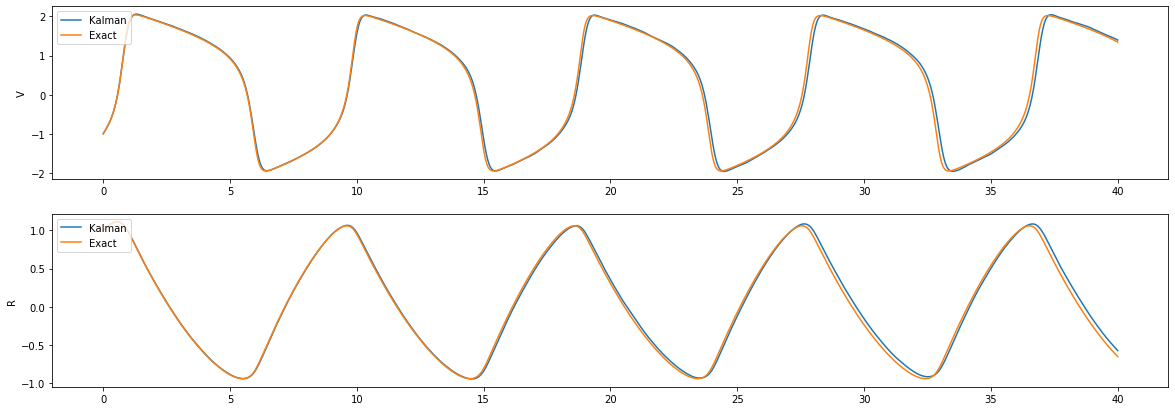

In [33]:
tseq = np.linspace(L, U, Nlst[-2])
exact = odeint(fitz, x0, tseq)

_, axs = plt.subplots(n, 1, figsize=(20, 7))
ylabel = ['V', 'R']
for i in range(n):
    axs[i].plot(tseq, Xn[:, p*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

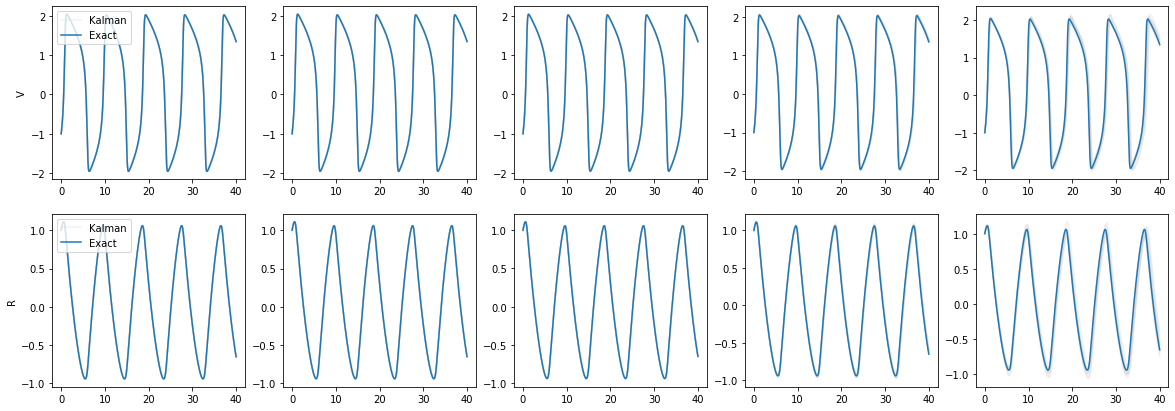

In [59]:
draws = 10
dim_example = len(Nlst)
Xn = [None]*dim_example
tseq = [None]*dim_example
X_exact = [None]*dim_example
for i in range(dim_example):
    Xn[i] = kalman_multi_solver(fitz2, L, U, Nlst[i], mu, sigmalst, rootlst, w_mat, a, draws)
    tseq[i] = np.linspace(L, U, Nlst[i])
    X_exact[i] = odeint(fitz, x0, tseq[i])

_, axs = plt.subplots(n, dim_example, figsize=(20, 7))
ylabel = ['V', 'R']
for prow in range(n):
    for pcol in range(dim_example):
        for i in range(draws):
            if i == (draws - 1):
                axs[prow, pcol].plot(tseq[pcol], Xn[pcol][i,:,p*prow], 
                                    color="lightgray", alpha=.3, label="Kalman")
            else:
                axs[prow, pcol].plot(tseq[pcol], Xn[pcol][i,:,p*prow], 
                                    color="lightgray", alpha=.3)
        axs[prow, pcol].plot(tseq[pcol], X_exact[pcol][:, prow], label='Exact')
        if pcol == 0:
            axs[prow, pcol].set_ylabel(ylabel[prow])
            axs[prow, pcol].legend(loc='upper left')
